# TopoCluster Regression

This is a simple, stripped-down notebook for training networks. I've removed most of the models that are present in `TopoClusterRegressionRewrite.ipynb`, as well as most of the plots (I find that the multitude of plots makes things a bit cumbersome and hard to navigate -- I'll see if I can change the way they are displayed later on).

Here, we just train the so-called `all` model, which uses images from all $6$ calo layers. We train two versions, for charged and neutral pions.

#### 1) Initial setup

In [ ]:
# ML fitting/loading/saving settings
loadModel = True # if false, then run trainings directly. otherwise load the file.
saveModel = False # if true, save the current model to disk.

Now let's choose our training data (and associated strategy).

In [ ]:
# training data choice
# options are jet, pion, pion_reweighted
strat = 'pion'

In [3]:
# Import some basic libraries.
import sys, os, uuid, glob
import numpy as np
import pandas as pd # we will use some uproot/pandas interplay here.
import uproot as ur
import ROOT as rt # used for plotting

# Import our resolution utilities
path_prefix = os.getcwd() + '/../'
if(path_prefix not in sys.path): sys.path.append(path_prefix)
from  util import resolution_util as ru
from  util import plot_util as pu
from  util import ml_util as mu
from  util import qol_util as qu # for progress bar

rt.gStyle.SetOptStat(0)
# use our custom dark style for plots
dark_style = qu.PlotStyle('dark')
dark_style.SetStyle() # still need to manually adjust legends, paves

plotpath = path_prefix + 'regression/Plots/'
modelpath = path_prefix + 'regression/Models/'
paths = [plotpath, modelpath]
for path in paths:
    try: os.makedirs(plotpath)
    except: pass

# metadata
layers = ["EMB1", "EMB2", "EMB3", "TileBar0", "TileBar1", "TileBar2"]
cell_size_phi = [0.098, 0.0245, 0.0245, 0.1, 0.1, 0.1]
cell_size_eta = [0.0031, 0.025, 0.05, 0.1, 0.1, 0.2]
len_phi = [4, 16, 16, 4, 4, 4]
len_eta = [128, 16, 8, 4, 4, 2]

Welcome to JupyROOT 6.22/02


#### 2) Get the training data.

Currently, we have two different available datasets (and "strategies").

    1) `pion`: This is our default strategy. The data corresponds with a simulation of a pion gun (giving us isolated pions).
    
    2) `jet`: In this strategy, we attempt training using some clusters from our jet data (what we're using to evaluate the network in the context of jet clustering). This is not proper training data - the topo-clusters were unlabeled -- so we have attempted to label them by the truth-level pion to which each was nearest. This labeling scheme might not actually be that meaningful, so beware! We're just trying this while waiting for *actual* training data that better mirrors the conditions of our jet dataset than the pion gun.

In [4]:
key_conversions = {
    'pp':'pi+',
    'pm':'pi-',
    'p0':'pi0'
}

if(strat == 'pion' or strat == 'pion_reweighted'):
    data_dir = path_prefix + 'data/pion/'
    data_filenames = {'pp':data_dir+'piplus.root','pm':data_dir+'piminus.root','p0':data_dir+'pi0.root'}
    
elif(strat == 'jet'):
    data_dir = path_prefix + 'jets/training/'
    data_filenames = {'pp':data_dir+'piplus.root','p0':data_dir+'pi0.root'}

paths = [modelpath, plotpath]
for i in range(len(paths)):
    path = paths[i]
    path = path + strat
    try: os.makedirs(path)
    except: pass
    path = path + '/'
    paths[i] = path
modelpath, plotpath = paths

data_files = {key:ur.open(val) for key,val in data_filenames.items()}
tree_name = 'ClusterTree'
data_trees = {key:val[tree_name] for key, val in data_files.items()}
branches = ['truthE', 'clusterE', 'clusterPt', 'clusterEta', 'cluster_ENG_CALIB_TOT']
#branches = ['clusterIndex', 'truthE', 'nCluster', 'clusterE', 'clusterECalib', 'clusterPt', 'clusterEta', 'clusterPhi', 'cluster_nCells', 'cluster_sumCellE', 'cluster_ENG_CALIB_TOT', 'cluster_ENG_CALIB_OUT_T', 'cluster_ENG_CALIB_DEAD_TOT', 'cluster_EM_PROBABILITY', 'cluster_HAD_WEIGHT', 'cluster_CENTER_MAG', 'cluster_FIRST_ENG_DENS', 'cluster_cellE_norm']
data_frames = {key:val.pandas.df(branches,flatten=False) for key,val in data_trees.items()}

#### Preparing training and testing samples

To begin with, note that as we're taking logarithms  of `clusterE` and `cluster_ENG_CALIB_TOT`, we will always require these to be greater than zero. So there are some events that we will **immediately discard** from the dataset. We won't use these at any point.

Of course, we may apply additional cuts on data -- we can use these cuts to define a *training set* and a *testing set*.

We'll train our networks on the training set, then evaluate them on both training and testing sets (and whole dataset, which may include events in neither).

In [5]:
training_frames = {}
testing_frames = {}

# First, the minimum energy cut that we will always apply to data. Anything that fails to pass this cut will be discarded,
# we will never evaluate on events that don't pass this cut.
global_energy_cut = 0.

# We apply a lower cut on cluster_ENG_CALIB_TOT, as very low-energy clusters can throw off training.
energy_cut = [0., -1.]
if(strat == 'pion' or strat == 'pion_reweighted'): 
    energy_cut[0] = 5.0e-1 # GeV
    energy_cut[1] = -1.
    
elif(strat == 'jet'): 
    energy_cut[0] = 5.0e-2 # GeV
    energy_cut[1] = -1.

data_indices = {} # indices of all usable data, i.e. non-zero energy
training_indices = {} # indices of events actually used for training
testing_indices = {} # indices of events not used for training (but usable)

# percent of events to hand over from training to testing
testing_frac = 0.2
rng = np.random.default_rng() # for shuffling indices when splitting training/testing

for key in data_frames.keys():
    
    n = len(data_frames[key])
    eng_calib_tot = data_frames[key]['cluster_ENG_CALIB_TOT'].to_numpy()
    selected_indices = eng_calib_tot > energy_cut[0]
    if(energy_cut[1] > 0.): selected_indices = selected_indices * (eng_calib_tot < energy_cut[1])
    
    selected_indices = selected_indices.nonzero()[0] # from boolean array to a list of actual indices
    rng.shuffle(selected_indices)
    n_test = int(0.2 * len(selected_indices))
    
    # making boolean arrays to select events -- arrays are of same length as dataframe
    testing_indices[key] = np.full(n,False)
    training_indices[key] = np.full(n,False)
    testing_indices[key][np.sort(selected_indices[:n_test])] = True
    training_indices[key][np.sort(selected_indices[n_test:])] = True
    training_frames[key] = data_frames[key][training_indices[key]].copy()
    testing_frames[key] = data_frames[key][testing_indices[key]].copy()

# #     testing_indices[key] = (data_frames[key]['cluster_ENG_CALIB_TOT'] > global_energy_cut).to_numpy()
# #     testing_indices[key] = testing_indices[key]^(testing_indices[key] * training_indices[key])

    data_indices[key] = (data_frames[key]['cluster_ENG_CALIB_TOT'] > global_energy_cut).to_numpy()
    data_frames[key] = data_frames[key][data_indices[key]]

Since we treat $\pi^+$ and $\pi^-$ as the same, let's combine them so that we have *charged* and *neutral* pions. We will store all the charged pions under the key `pp`, and delete the key `pm`.

In [6]:
key_conversion = {'pp':'charged pion','p0':'neutral pion'}
# combining dataframes
if('pm' in data_frames.keys()):
    data_frames['pp'] = data_frames['pp'].append(data_frames['pm'])
    del data_frames['pm']
    
    training_frames['pp'] = training_frames['pp'].append(training_frames['pm'])
    del training_frames['pm']
    
    testing_frames['pp'] = testing_frames['pp'].append(testing_frames['pm'])
    del testing_frames['pm']

for key in data_frames.keys():
    print('Number of {type} training/testing events: {val1}/{val2}'.format(type=key_conversion[key], val1 = np.sum(training_indices[key]), val2 = np.sum(testing_indices[key])))

Number of charged pion training/testing events: 261873/65468
Number of neutral pion training/testing events: 196960/49240


Note that we have many more charged pions than neutral pions, so this *may* result in our charged pion regression being better-trained (unless the stats for both are sufficiently high).

In [7]:
from sklearn.preprocessing import StandardScaler

# some regression vars
for key,frame in data_frames.items():
    frame['logE'] = np.log(frame['clusterE'])
    frame['logECalib'] = np.log(frame['cluster_ENG_CALIB_TOT'])
    
for key,frame in training_frames.items():
    frame['logE'] = np.log(frame['clusterE'])
    frame['logECalib'] = np.log(frame['cluster_ENG_CALIB_TOT'])

for key,frame in testing_frames.items():
    frame['logE'] = np.log(frame['clusterE'])
    frame['logECalib'] = np.log(frame['cluster_ENG_CALIB_TOT'])

In [8]:
# create scalers
scaler_e = {key:StandardScaler() for key in data_frames.keys()}
scaler_cal = {key:StandardScaler() for key in data_frames.keys()}
scaler_eta = {key:StandardScaler() for key in data_frames.keys()}

# fit our scalers, using the training data
for key, frame in training_frames.items():
    scaler_e[key].fit(frame['logE'].to_numpy().reshape(-1,1))
    scaler_cal[key].fit(frame['logECalib'].to_numpy().reshape(-1,1))
    scaler_eta[key].fit(frame['clusterEta'].to_numpy().reshape(-1,1))
    
# now apply our scalers to our data (training, testing and combo)
for key, frame in training_frames.items():
    frame['s_logE'] = scaler_e[key].transform(frame['logE'].to_numpy().reshape(-1,1))
    frame['s_logECalib'] = scaler_cal[key].transform(frame['logECalib'].to_numpy().reshape(-1,1))
    frame['s_eta'] = scaler_eta[key].transform(frame['clusterEta'].to_numpy().reshape(-1,1))
    
for key, frame in testing_frames.items():
    frame['s_logE'] = scaler_e[key].transform(frame['logE'].to_numpy().reshape(-1,1))
    frame['s_logECalib'] = scaler_cal[key].transform(frame['logECalib'].to_numpy().reshape(-1,1))
    frame['s_eta'] = scaler_eta[key].transform(frame['clusterEta'].to_numpy().reshape(-1,1))

for key, frame in data_frames.items():
    frame['s_logE'] = scaler_e[key].transform(frame['logE'].to_numpy().reshape(-1,1))
    frame['s_logECalib'] = scaler_cal[key].transform(frame['logECalib'].to_numpy().reshape(-1,1))
    frame['s_eta'] = scaler_eta[key].transform(frame['clusterEta'].to_numpy().reshape(-1,1))

To finish training data preparation, we concatenate the calorimeter images, and then combine them with columns `s_logE` and `s_Eta`.

To avoid running out of memory -- which can be an issue depending on where this notebook is run -- we can perform some garbage collection and delete the contents of `calo_images` as they are incorporated into `All_input`, our combined network training input.

Here's a handy function for taking a DataFrame (with our scaler-derived columns) and our tree with calo images, and getting the actual network input we need. The `indices` argument is just used for `dtree`, whereas `dframe` should already have the indices applied.

In [9]:
def CombinedInput(dframe, dtree, indices=-1, merge=True):
    # Prepare the calo images for input to training.
    l = len(layers) * len(dtree.keys())
    i = 0
    pfx = 'Loading calo images:      '
    sfx = 'Complete'
    bl = 50
    qu.printProgressBarColor(i, l, prefix=pfx, suffix=sfx, length=bl)

    calo_images = {}
    for key in dtree.keys():
        calo_images[key] = {}
    
        for layer in layers:
            if(indices != -1): calo_images[key][layer] = mu.setupCells(dtree[key],layer, indices = indices[key])
            else: calo_images[key][layer] = mu.setupCells(dtree[key],layer)
            i += 1
            qu.printProgressBarColor(i, l, prefix=pfx, suffix=sfx, length=bl)
    
    #TODO: A bit hacky, but works for now. Dealing with DataFrames and uproot TTree's together is awful...
    # Importantly, the merge here is in the same order as above.
    if(merge):
        for layer in layers:
            calo_images['pp'][layer] = np.row_stack((calo_images['pp'][layer],calo_images['pm'][layer]))
        del calo_images['pm']
        
    # Concatenate images, and prepare our combined input.
    All_input = {}
    keys = list(calo_images.keys())
    l = 3 * len(keys)
    i = 0
    pfx = 'Preparing combined input: '
    qu.printProgressBarColor(i, l, prefix=pfx, suffix=sfx, length=bl)

    for key in keys:
        combined_images = np.concatenate(tuple([calo_images[key][layer] for layer in layers]), axis=1)
        del calo_images[key] # delete this element of calo_images, it has been copied and is no longer needed
        i = i + 1
        qu.printProgressBarColor(i, l, prefix=pfx, suffix=sfx, length=bl)

        s_combined,scaler_combined = mu.standardCells(combined_images, layers)
        i = i + 1
        qu.printProgressBarColor(i, l, prefix=pfx, suffix=sfx, length=bl)

        All_input[key] = np.column_stack((dframe[key]['s_logE'], dframe[key]['s_eta'],s_combined))
        i = i + 1
        qu.printProgressBarColor(i, l, prefix=pfx, suffix=sfx, length=bl)
    return All_input

In [10]:
All_input = CombinedInput(training_frames, data_trees,training_indices)

Loading calo images:       |██████████████████████████████████████████████████| 100.0% Complete
Preparing combined input:  |██████████████████████████████████████████████████| 100.0% Complete


We may optionally perform some re-weighting of our training events. If using the `pion_reweighted` strategy, we will re-weight our single-pion training data to match the topo-cluster $p_T$ spectrum of our jet data.

In [11]:
sample_weights = {}
if(strat == 'pion_reweighted'):
    pt_min = 0.
    pt_max = 20.
    pt_bins = 100
    
    # Get the jet files for reweighting. We look in jets/ to make sure we only use the relevant files.
    jet_files = glob.glob(path_prefix + 'jets/data/*.root')
    
    for key in training_frames.keys():
        h_train    = rt.TH1F(qu.RN(), 'h_train',   pt_bins, pt_min, pt_max)
        h_reweight = rt.TH1F(qu.RN(), 'h_reweight',pt_bins, pt_min, pt_max)

        # fill training distribution
        training_vals = training_frames[key]['clusterPt'].to_numpy()
        for entry in training_vals: h_train.Fill(entry)
        h_train.Scale(1./h_train.Integral())
        
        # fill the reweighting distribution
        for file in jet_files:
            for entry in ur.open(file)['ClusterTree'].array('clusterPt').flatten():
                h_reweight.Fill(entry)
        h_reweight.Scale(1./h_reweight.Integral())
        h_reweight = h_reweight / h_train
        
        # now get a list of weights for our events
        sample_weights[key] = np.array([h_reweight.GetBinContent(h_reweight.FindBin(x)) for x in training_vals])
    
else:  sample_weights = {key:np.full(len(All_input[key]), 1.) for key in All_input.keys()}

## Training "all" model

In [12]:
from tensorflow.keras import regularizers
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import load_model

In [13]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # disable some of the tensorflow info printouts, only display errors

import tensorflow as tf
strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])
ngpu = strategy.num_replicas_in_sync
print ('Number of devices: {}'.format(ngpu))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [14]:
def baseline_nn_All_model():
    number_pixels = 512 + 256 + 128 + 16 + 16 + 8
    # create model
    with strategy.scope():    
        model = Sequential()
        used_pixels = number_pixels + 2
#     if number_pixels < 128:
#         used_pixels = 128
        model.add(Dense(used_pixels, input_dim=used_pixels, kernel_initializer='normal', activation='relu'))
        # model.add(Dropout(0.2))
        model.add(Dense(used_pixels, activation='relu'))
        # model.add(Dropout(0.2))
        model.add(Dense(int(used_pixels/2), activation='relu'))
        # model.add(Dropout(0.2))
        model.add(Dense(units=1, kernel_initializer='normal', activation='linear'))
        opt = Adam(lr=1e-4, decay=1e-6)
        model.compile(optimizer=opt, loss='mse',metrics=['mae','mse'])
    return model

In [15]:
# Print some summary info for this model
print(baseline_nn_All_model().summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 938)               880782    
_________________________________________________________________
dense_1 (Dense)              (None, 938)               880782    
_________________________________________________________________
dense_2 (Dense)              (None, 469)               440391    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 470       
Total params: 2,202,425
Trainable params: 2,202,425
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
# Define our regressors (actual networks) that we will fit (train).
batch_size = 200 * ngpu
epochs = 100 # 100
verbose = 1
regressors = {key: KerasRegressor(build_fn=baseline_nn_All_model, batch_size=batch_size, epochs=epochs, verbose=verbose) for key in All_input.keys()}

In [17]:
# Train the models and save them, or load them from files.
model_file_names = {'pp':modelpath + 'all_charged.h5','p0':modelpath + 'all_neutral.h5'}
assert (set(model_file_names.keys()) == set(All_input.keys()))
histories = {}

for key, filename in model_file_names.items():
    if not loadModel: histories[key] = regressors[key].fit(All_input[key], training_frames[key]['s_logECalib'], sample_weight = sample_weights[key])
    else: regressors[key].model = load_model(model_file_names[key])

    if saveModel: regressors[key].model.save(model_file_names[key])

We can now evaluate the networks on *all* our data to see how they've done. This will involve overwriting some training data variables that we won't need for plotting results.

In [18]:
# First, the training data
print('Getting predictions for training data.')
for key, frame in training_frames.items():
    frame['clusterE_pred'] = np.exp(scaler_cal[key].inverse_transform(regressors[key].predict(All_input[key])))

# Now regenerate All_input for our testing data, and get predictions for it
print('Getting predictions for testing data.')
All_input = CombinedInput(testing_frames, data_trees, testing_indices)
for key, frame in testing_frames.items():
    frame['clusterE_pred'] = np.exp(scaler_cal[key].inverse_transform(regressors[key].predict(All_input[key])))

# Now regenerate All_input for training + testing, get predictions.
All_input = CombinedInput(data_frames, data_trees, data_indices)
for key, frame in data_frames.items():
    frame['clusterE_pred'] = np.exp(scaler_cal[key].inverse_transform(regressors[key].predict(All_input[key])))

Getting predictions for training data.
985/985 [==============================] - 2s 2ms/step
Getting predictions for testing data.
Loading calo images:       |██████████████████████████████████████████████████| 100.0% Complete
Preparing combined input:  |██████████████████████████████████████████████████| 100.0% Complete
247/247 [==============================] - 1s 2ms/step
Loading calo images:       |██████████████████████████████████████████████████| 100.0% Complete
Preparing combined input:  |██████████████████████████████████████████████████| 100.0% Complete
1320/1320 [==============================] - 3s 2ms/step


## Plotting results (testing how well our network works)

Now, let's plot some kinematics and network results. We'll make two groups of plots -- one for charged pions and one for neutral pions.

Within each group of plots, we'll make two plots for each quantity -- one made using just the training data, and then one made using all the data (training + whatever we excluded -- but still excluding events with `cluster_ENG_CALIB_TOT` $< 0$ since these blow up network output).

In [19]:
def Median(values, counts, default = 1):
    nvar = len(values)
    assert(len(counts) == nvar)
    if(nvar == 0): return default
    value_list = [[values[i] for j in range(int(counts[i]))] for i in range(nvar)]
    value_array = [item for sublist in value_list for item in sublist]
    value_array = np.array(value_array)
    if(len(value_array) == 0): return default
    med = np.median(value_array)
    return med

In [20]:
def SetColor(hist, color, alpha = 1., style=0):
    hist.SetFillColorAlpha(color, alpha)
    hist.SetLineColor(color)
    if(style != 0): hist.SetFillStyle(style)
    return

# a simple version of Max's cool 2D plots
def EnergyPlot2D(e1, e2, title='title;x;y', nbins = [100,35], x_range = [0.,2000.], y_range = [0.3, 1.7], offset=False, mode = 'median'):
    hist = rt.TH2F(qu.RN(), title, nbins[0], x_range[0], x_range[1], nbins[1], y_range[0], y_range[1])
    x_vals = e2
    y_vals = e1/e2
    if(offset): x_vals = x_vals + 1.
    
    for i in range(len(e2)):
        hist.Fill(x_vals[i],y_vals[i])
        
    # now we want to make a curve representing the medians/means in y
    bin_centers_y = np.array([hist.GetYaxis().GetBinCenter(i+1) for i in range(nbins[1])])
    mean_vals = np.zeros(nbins[0])
    for i in range(nbins[0]):
        weights = np.array([hist.GetBinContent(i+1, j+1) for j in range(nbins[1])])
        if(mode == 'median'):
            mean_vals[i] = Median(bin_centers_y,np.array(weights,dtype=np.dtype('i8')))
        else:
            if(np.sum(weights) != 0.):
                weights = weights / np.sum(weights)
                y_vals = np.array([hist.GetYaxis().GetBinCenter(j+1) for j in range(nbins[1])])
                y_vals = np.multiply(y_vals,weights)
                mean_vals[i] = np.sum(y_vals)
            else: mean_vals[i] = 1.
        
    x_vals = np.array([hist.GetXaxis().GetBinCenter(i+1) for i in range(nbins[0])])
    curve = rt.TGraph(nbins[0],x_vals, mean_vals)
    curve.SetLineColor(rt.kRed)
    curve.SetLineWidth(2)
    return curve, hist

In [21]:
# some ranges for the plots
if(strat == 'pion' or strat == 'pion_reweighted'):
    max_energy = 2000. # GeV
    max_energy_2d = max_energy
    bin_energy = 300
    ratio_range_2d = [0.3, 1.7]
    bins_2d = [200,70]
    offset_2d = False
    
else:
    max_energy = 100
    max_energy_2d = 10.
    bin_energy = 20
    ratio_range_2d = [0., 5.]
    bins_2d = [50,125]
    offset_2d = True

Info in <TCanvas::Print>: pdf file /local/home/jano/ml4pions/LCStudies/regression/../regression/Plots/pion/p0_plots.pdf has been created
Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/regression/../regression/Plots/pion/p0_plots.png has been created
Info in <TCanvas::Print>: pdf file /local/home/jano/ml4pions/LCStudies/regression/../regression/Plots/pion/pp_plots.pdf has been created
Info in <TCanvas::Print>: png file /local/home/jano/ml4pions/LCStudies/regression/../regression/Plots/pion/pp_plots.png has been created


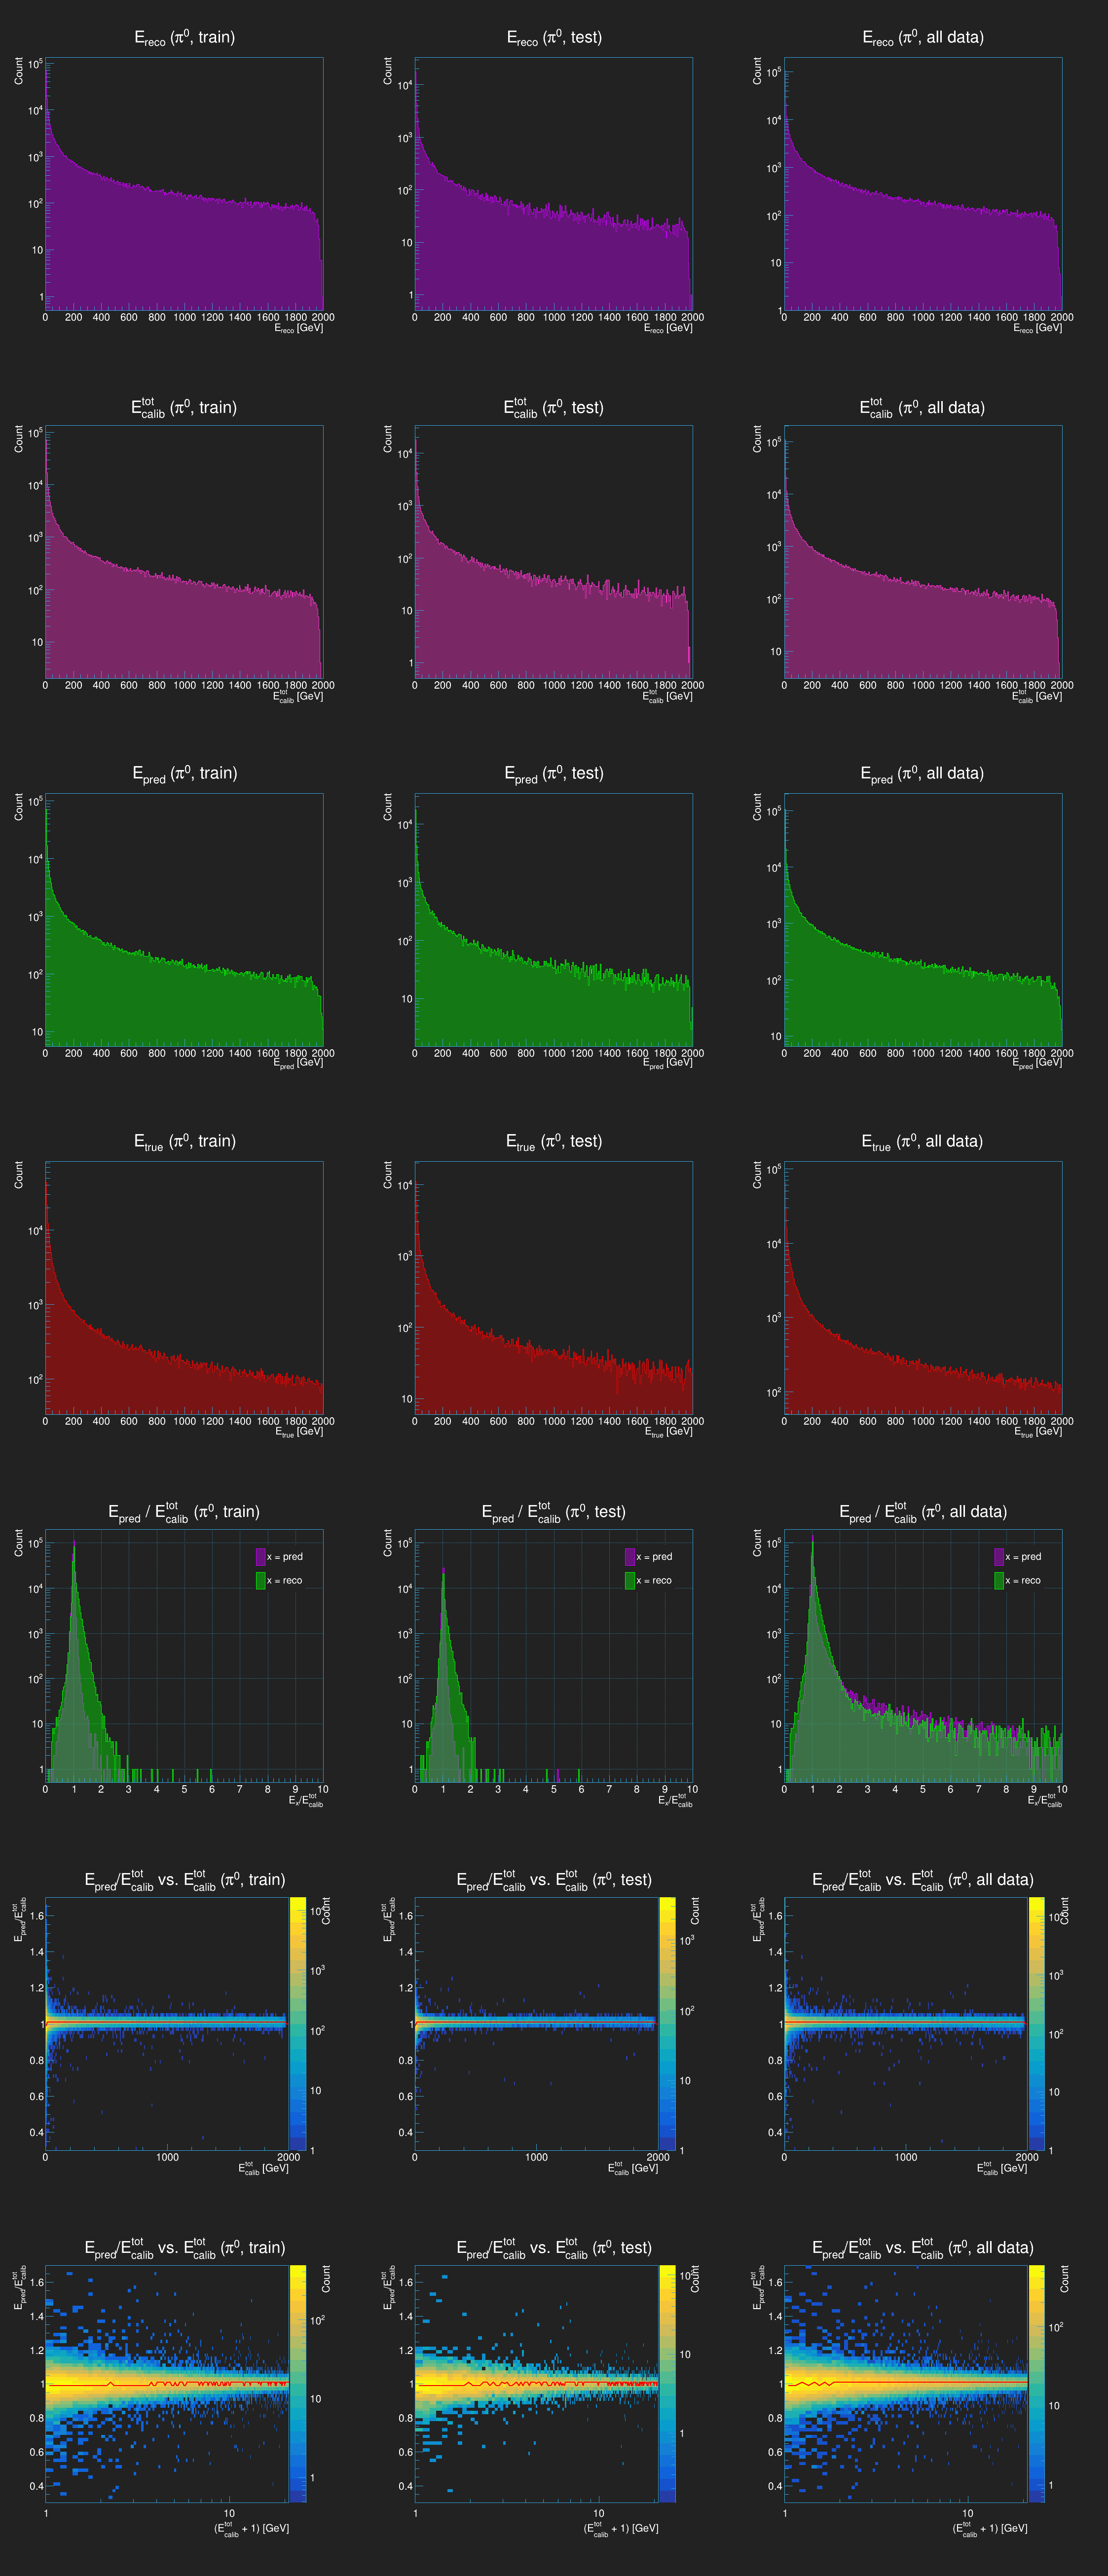

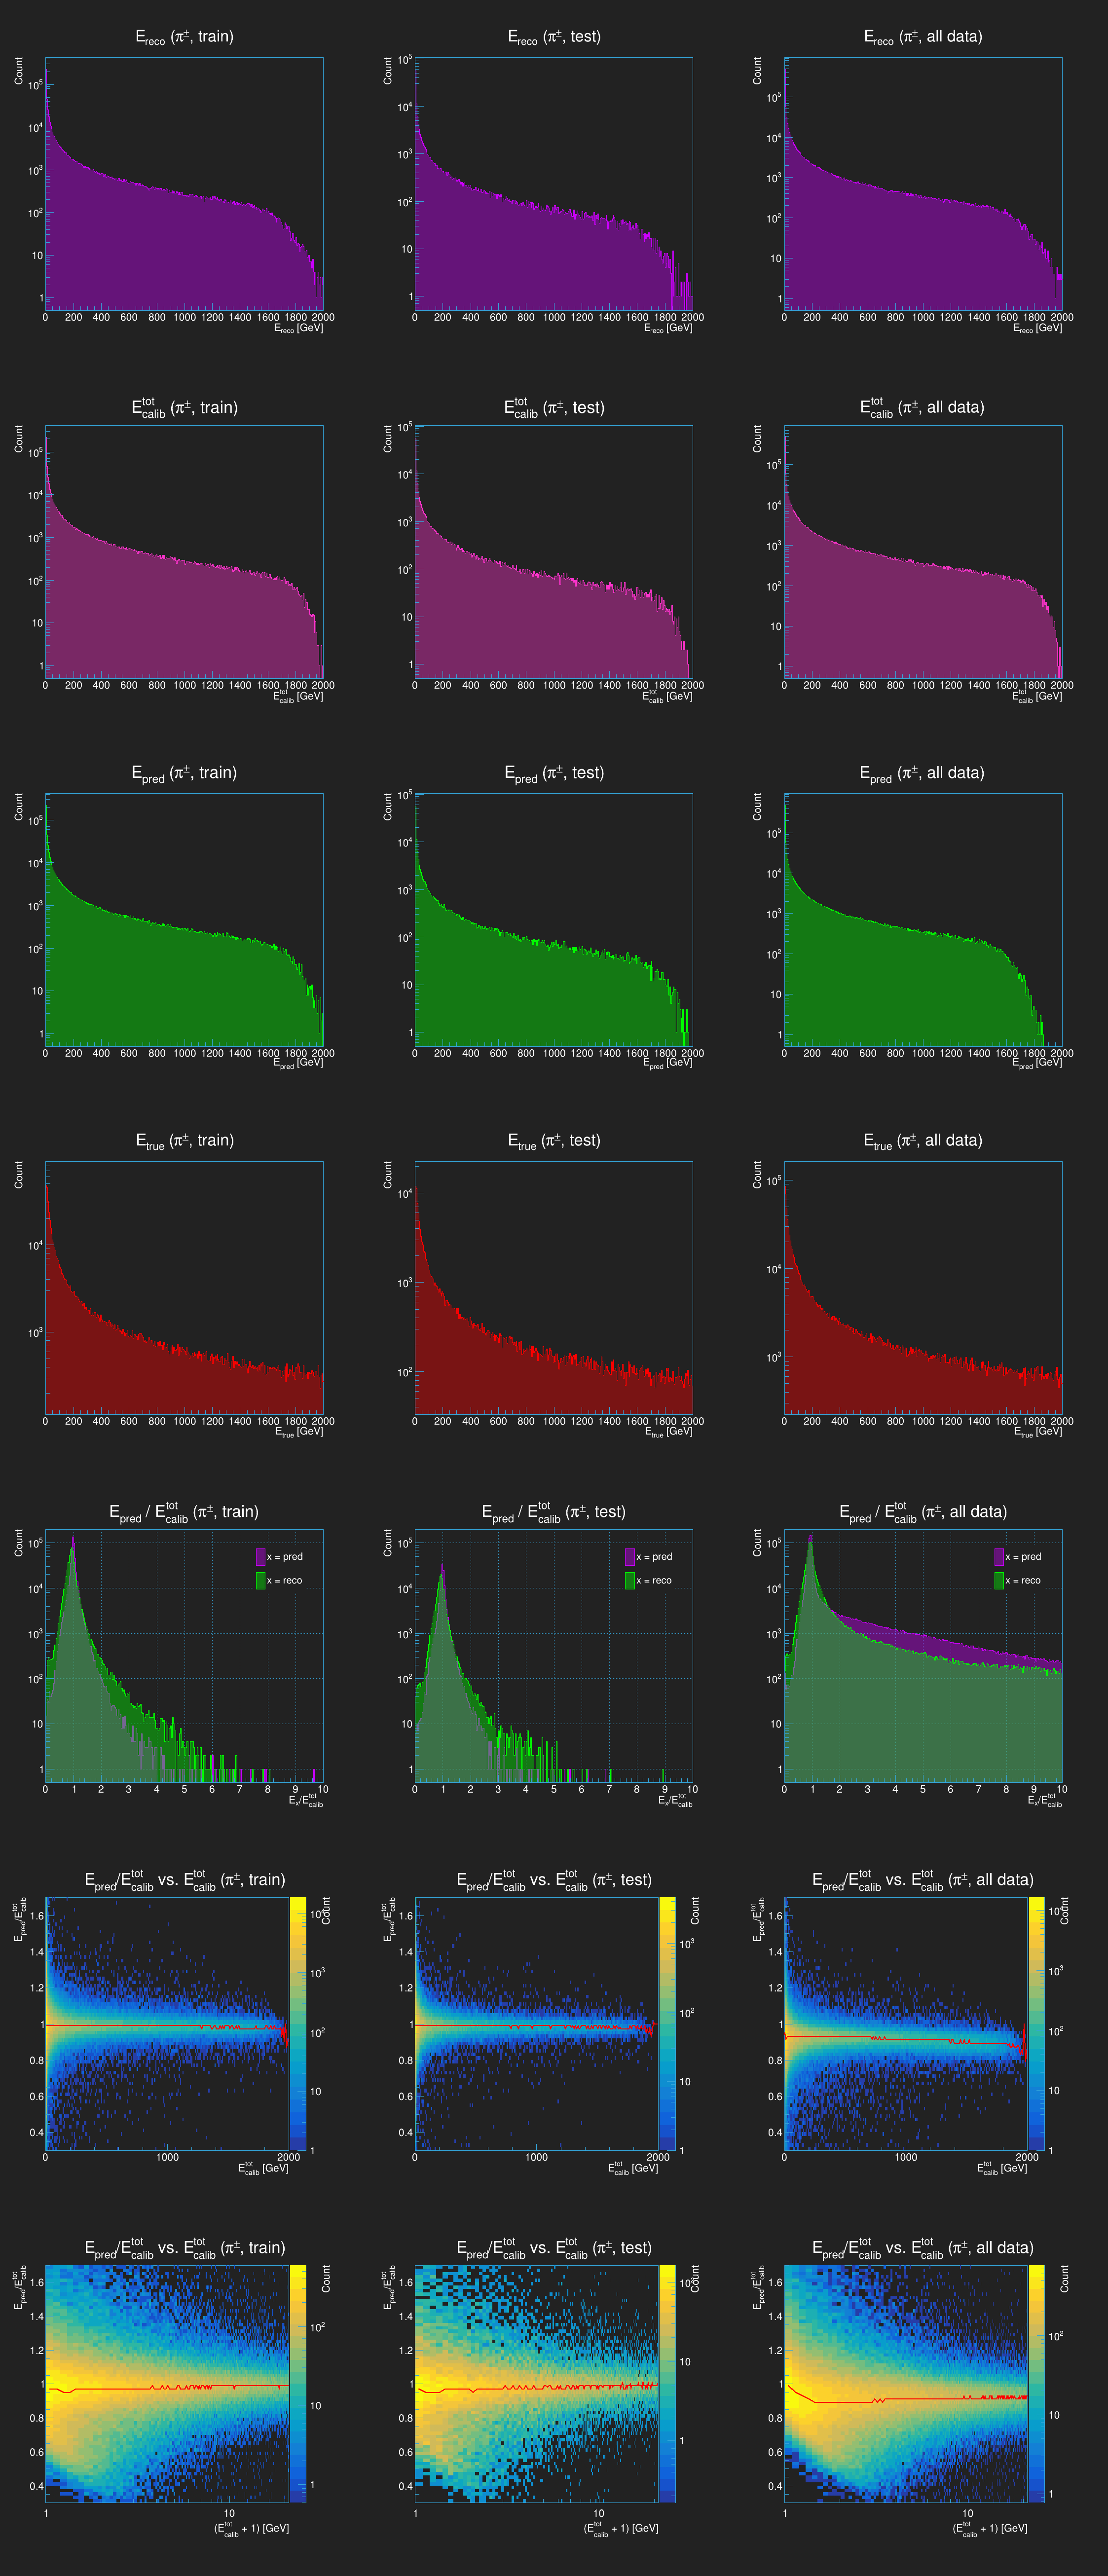

In [22]:
clusterE = {}
clusterE_calib = {}
clusterE_pred = {}
clusterE_true = {}
clusterE_ratio1 = {} # ratio of predicted cluster E to calibrated cluster E
clusterE_ratio2 = {} # ratio of reco cluster E to calibrated cluster E
clusterE_ratio2D = {} # 2D plot, ratio1 versus calibrated cluster E
clusterE_ratio2D_zoomed = {} # 2D plot, ratio1 versus calibrated cluster E, zoomed

mean_curves = {}
mean_curves_zoomed = {}

canvs = {}
legends = {}
stacks = {}

key_conversions = {
    'pp':'#pi^{#pm}',
    'p0':'#pi^{0}',
    'check':'#pi^{+} (check)'}

dsets = {
    'train': training_frames,
    'test': testing_frames,
    'all data': data_frames
}

extensions = ['pdf','png']
plot_size = 750

for key in ['p0','pp']:
    clusterE[key] = {}
    clusterE_calib[key] = {}
    clusterE_pred[key] = {}
    clusterE_true[key] = {}
    clusterE_ratio1[key] = {}
    clusterE_ratio2[key] = {}
    clusterE_ratio2D[key] = {}
    clusterE_ratio2D_zoomed[key] = {}
    
    mean_curves[key] = {}
    mean_curves_zoomed[key] = {}

    canvs[key] = {}
    legends[key] = {}
    stacks[key] = {}
    
    for dkey, frame in dsets.items():
        key2 = '(' + key_conversions[key] + ', ' + dkey + ')'
        clusterE[key][dkey] = rt.TH1F(qu.RN(), 'E_{reco} ' + key2 +'; E_{reco} [GeV];Count' , bin_energy,0.,max_energy)
        clusterE_calib[key][dkey] = rt.TH1F(qu.RN(), 'E_{calib}^{tot} ' + key2 + ';E_{calib}^{tot} [GeV];Count', bin_energy,0.,max_energy)
        clusterE_pred[key][dkey] = rt.TH1F(qu.RN(), 'E_{pred} ' + key2 + ';E_{pred} [GeV];Count', bin_energy,0.,max_energy)
        clusterE_true[key][dkey] = rt.TH1F(qu.RN(), 'E_{true} ' + key2 + ';E_{true} [GeV];Count', bin_energy,0.,max_energy)
        clusterE_ratio1[key][dkey] = rt.TH1F(qu.RN(), 'E_{pred} / E_{calib}^{tot} ' + key2 + ';E_{pred}/E_{calib}^{tot};Count', 250,0.,10.)
        clusterE_ratio2[key][dkey] = rt.TH1F(qu.RN(), 'E / E_{calib}^{tot} ' + key2 + ';E_{reco}/E_{calib}^{tot]};Count', 250,0.,10.)

        SetColor(clusterE[key][dkey], rt.kViolet, alpha = 0.4)
        SetColor(clusterE_calib[key][dkey], rt.kPink + 9, alpha = 0.4)
        SetColor(clusterE_pred[key][dkey], rt.kGreen, alpha = 0.4)
        SetColor(clusterE_true[key][dkey], rt.kRed, alpha = 0.4)
        SetColor(clusterE_ratio1[key][dkey], rt.kViolet, alpha = 0.4)
        SetColor(clusterE_ratio2[key][dkey], rt.kGreen, alpha = 0.4)

        meas   = frame[key]['clusterE'].to_numpy()
        calib  = frame[key]['cluster_ENG_CALIB_TOT'].to_numpy()
        pred   = frame[key]['clusterE_pred'].to_numpy()
        true   = frame[key]['truthE'].to_numpy()
        ratio1 = pred / calib
        ratio2 = meas / calib
    
        for i in range(len(meas)):
            clusterE[key][dkey].Fill(meas[i])
            clusterE_calib[key][dkey].Fill(calib[i])
            clusterE_pred[key][dkey].Fill(pred[i])
            clusterE_true[key][dkey].Fill(true[i])
            clusterE_ratio1[key][dkey].Fill(ratio1[i])
            clusterE_ratio2[key][dkey].Fill(ratio2[i])
            
        # fill the histogram stacks
        stacks[key][dkey] = rt.THStack(qu.RN(), clusterE_ratio1[key][dkey].GetTitle())
        stacks[key][dkey].Add(clusterE_ratio1[key][dkey])
        stacks[key][dkey].Add(clusterE_ratio2[key][dkey])

        # 2D plots
        title = 'E_{pred}/E_{calib}^{tot} vs. E_{calib}^{tot} ' + key2 + ';E_{calib}^{tot} [GeV];E_{pred}/E_{calib}^{tot};Count'
        x_range = [0.,max_energy_2d]
        nbins = bins_2d
        mean_curves[key][dkey], clusterE_ratio2D[key][dkey] = EnergyPlot2D(pred, calib, nbins = nbins, x_range = x_range, y_range = ratio_range_2d, title=title, offset=True)

        title = 'E_{pred}/E_{calib}^{tot} vs. E_{calib}^{tot} ' + key2 + ';(E_{calib}^{tot} + 1) [GeV];E_{pred}/E_{calib}^{tot};Count'
        x_range = [1.,1. + 0.01 * max_energy_2d]
        nbins = bins_2d
        nbins[0] = nbins[0] - 1
        mean_curves_zoomed[key][dkey], clusterE_ratio2D_zoomed[key][dkey] = EnergyPlot2D(pred, calib, nbins = nbins, x_range = x_range, y_range = ratio_range_2d, title=title, offset=False)

    plots = [clusterE, clusterE_calib, clusterE_pred, clusterE_true, stacks, clusterE_ratio2D, clusterE_ratio2D_zoomed]
    dkeys = list(dsets.keys())
    # make legend for the overlapping plots
    legends[key] = rt.TLegend(0.7,0.7,0.85,0.85)
    legends[key].SetBorderSize(0)
    legends[key].AddEntry(clusterE_ratio1[key][dkeys[0]],'x = pred','f')
    legends[key].AddEntry(clusterE_ratio2[key][dkeys[0]],'x = reco','f')
    
    nx = len(dkeys)
    ny = len(plots)
    canvs[key] = rt.TCanvas(qu.RN(),'c_'+str(key),nx * plot_size,ny * plot_size)
    canvs[key].Divide(nx,ny)
    
    for i, plot in enumerate(plots):
        
        if(plot == stacks):
            x = nx * i + 1
            for j, dkey in enumerate(dkeys):
                canvs[key].cd(x + j)
                plot[key][dkey].Draw('NOSTACK HIST')
                rt.gPad.SetLogy()
                rt.gPad.SetGrid()
                plot[key][dkey].GetHistogram().GetXaxis().SetTitle('E_{x}/E_{calib}^{tot}')
                plot[key][dkey].GetHistogram().GetYaxis().SetTitle(clusterE_ratio1[key][dkey].GetYaxis().GetTitle())
                
                if(strat == 'jet'):
                    plot[key][dkey].SetMinimum(5.0e-1)
                    plot[key][dkey].SetMaximum(1.0e3)
                    
                else:
                    plot[key][dkey].SetMinimum(5.0e-1)
                    plot[key][dkey].SetMaximum(2.0e5)   
                    
                legends[key].SetTextColor(dark_style.text)
                legends[key].Draw()

        elif(plot == clusterE_ratio2D or plot == clusterE_ratio2D_zoomed):
            x = nx * i + 1
            for j, dkey in enumerate(dkeys):
                canvs[key].cd(x + j)
                plot[key][dkey].Draw('COLZ')
                if(plot == clusterE_ratio2D):
                    mean_curves[key][dkey].Draw('SAME')

                else: 
                    mean_curves_zoomed[key][dkey].Draw('SAME')
                    rt.gPad.SetLogx()
                    rt.gPad.SetBottomMargin(0.15)
                    plot[key][dkey].GetXaxis().SetTitleOffset(1.5)
                    
                rt.gPad.SetLogz()
                rt.gPad.SetRightMargin(0.2)
                plot[key][dkey].GetXaxis().SetMaxDigits(4)
                  
        else:
            x = nx * i + 1
            for j, dkey in enumerate(dkeys):
                canvs[key].cd(x + j)
                plot[key][dkey].Draw('HIST')
                rt.gPad.SetLogy()
    
    # Draw the canvas
    canvs[key].Draw()
    
    # Save the canvas as a PDF & PNG image.
    image_name = key + '_plots'
    for ext in extensions: canvs[key].SaveAs(plotpath + image_name + '.' + ext)

For `pion`:

    - Both of our regressions appear to be working quite well -- we see that our predicted energy (bottom left plot, dark blue) outperforms the reconstructed energy (bottom left plot, cyan) as the peaks aren't as wide while still being centered on $1$ as we would like.
    
For `jet`:

    - Note that our energy range is quite different than with our `pion` training data. It seems that the isolated pions were often far more energetic -- or at least led to far more energetic topo-clusters -- than do our jets. The results don't look terrible when evaluating within the training set, but we see that including events that weren't used for training, which corresponds with very low `cluster_ENG_CALIB_TOT` values, throws things off. The network extrapolates very poorly towards these lower energies.

In [23]:
# # Just double-checking the range of cluster_ENG_CALIB_TOT in the training/plotting data
# minimum = np.min(data_frames['pp']['cluster_ENG_CALIB_TOT'].to_numpy())
# maximum = np.max(data_frames['pp']['cluster_ENG_CALIB_TOT'].to_numpy())
# print('({val1:.1e},{val2:.1e})'.format(val1=minimum, val2=maximum))